# Simplified U1 leptoquark model

In this notebook, we will use `likelihoodfits` to study a simplified model of leptoquarks, proposed in [arXiv:2109.07405](https://arxiv.org/abs/2109.07405), to describe the RK and RD anomalies with just two parameters.

## Importing the packages

In [1]:
import numpy as np

`wilson` is used to handle the Wilson coefficients and run the RGE. 

In [2]:
from wilson import Wilson

`smelli` implements the global likelihood function.

In [3]:
import smelli

`rich` is used to display a progress bar

In [4]:
from rich.progress import track

To easily iterate over the cartesian product of two iterables (i.e., a grid)

In [5]:
from itertools import product

And finally, `likelihoodfits`

In [6]:
import likelihoodfits

## Defining the Wilson coefficients

In [7]:
def lqU1_simple(x1: float, x3: float, M: float) -> Wilson:
    cee = -0.5*x1**2/M**2
    cetau = -0.5*x1*x3/M**2
    ctautau = -0.5*x3**2/M**2
    coeffs = {}
    for c in ['1122', '1123', '1133']:
        coeffs.update({'lq1_'+c: cee})
        coeffs.update({'lq3_'+c: cee})
    for c in ['1322', '1323', '1332', '1333']:
        coeffs.update({'lq1_'+c: cetau})
        coeffs.update({'lq3_'+c: cetau})
    for c in ['3322', '3323', '3333']:
        coeffs.update({'lq1_'+c: ctautau})
        coeffs.update({'lq3_'+c: ctautau})
    w = Wilson(coeffs, M, 'SMEFT', 'Warsaw')
    w.set_option('smeft_accuracy', 'leadinglog')
    return w

## Calculating the likelihoods
A real calculation can take several hours. For illustration purposes, we will use a small grid to calculate the likelihood.

In [8]:
NDATA = 5

Here we define the grid points in the x and y directions

In [9]:
x1 = likelihoodfits.Axis(np.linspace(0.0, 0.08, NDATA), 'x1', r'$x_1$')
x3 = likelihoodfits.Axis(np.linspace(0.0, 0.8, NDATA), 'x3', r'$x_3$')
lhr = likelihoodfits.LikelihoodResults(x1, x3)

We add the smelli likelihoods that we want to store

In [10]:
lhr.new_likelihood('likelihood_lfv.yaml', 'LFV')
lhr.new_likelihood('likelihood_lfu_fcnc.yaml',
                    r'$b\to s \ell^+\ell^-$ LFU')
lhr.new_likelihood('likelihood_rd_rds.yaml', r'$b \to c \ell \nu$ LFU')
#lhr.new_likelihood('likelihood_ewpt.yaml', 'EW precision')
lhr.new_likelihood('global', 'Global')

Preparing the global likelihood

In [11]:
gl = smelli.GlobalLikelihood()
# This function returns a dictionary with the wanted likelihoods
def fun(x, y):
    return gl.parameter_point(lqU1_simple(x, y, 1500)).log_likelihood_dict()

We calculate point-by-point, so we can see the progress

In [13]:
for ix, iy in track(product(range(lhr.x.len), range(lhr.y.len)), total=NDATA*NDATA):
    lhr.calculate_point(fun, ix, iy)

Output()

And we save it as a HDF5 file

In [14]:
path = 'data/lqU1_simple_mini.hdf5'
lhr.to_hdf5(path)

## Plotting

We will plot the full (`NDATA = 50`) likelihood

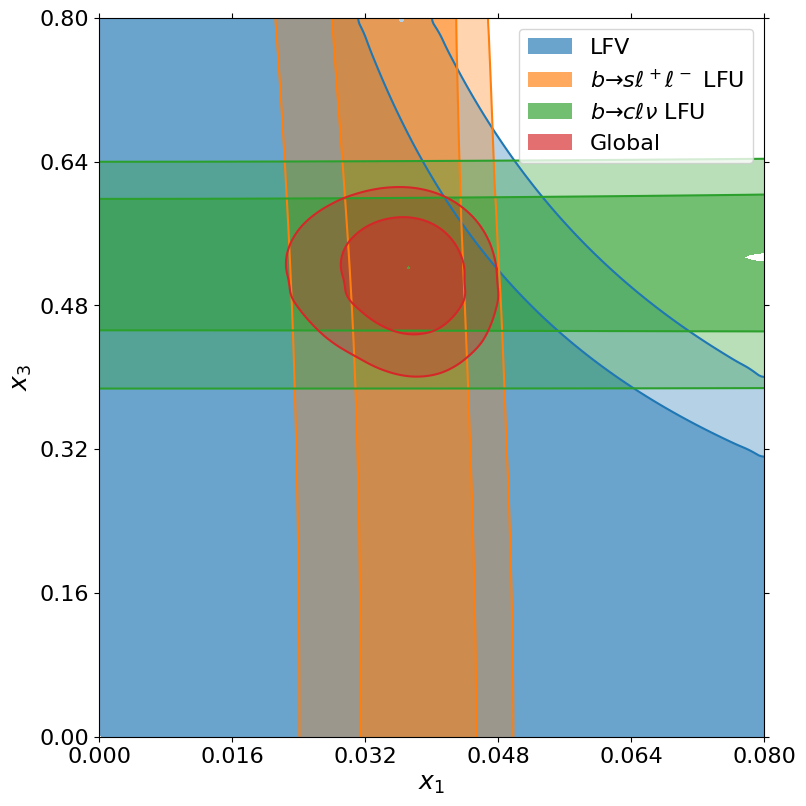

In [15]:
lhfull = likelihoodfits.LikelihoodResults.from_hdf5('data/lqU1_simple.hdf5')
fig = likelihoodfits.plot.plot(lhfull)

We should move the legend to the bottom

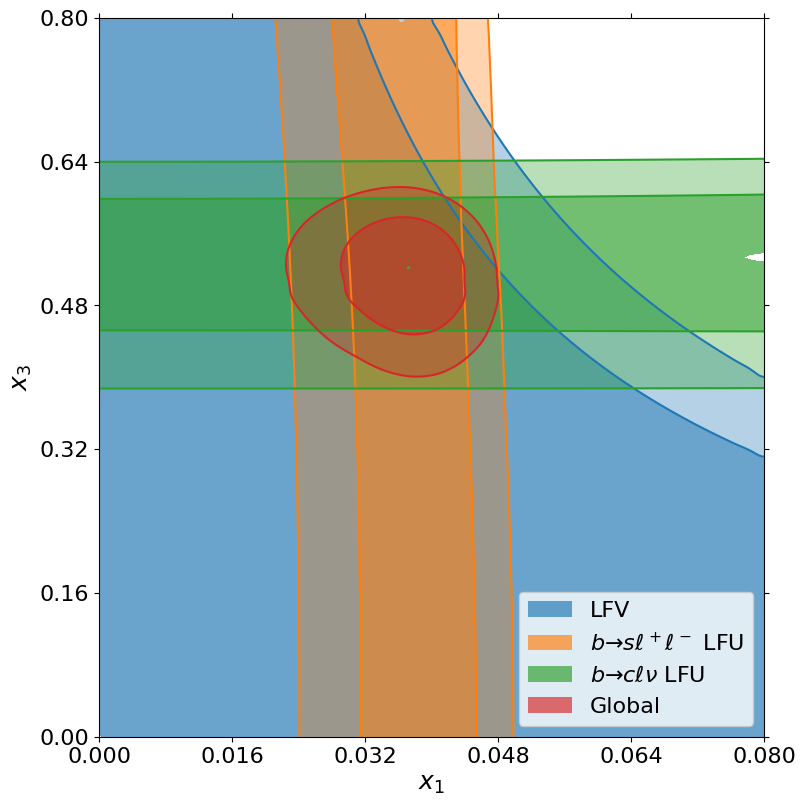

In [16]:
fig = likelihoodfits.plot.plot(lhfull, loc='lower right')

How about changing the colors? We can add a `palette` argument, with a list of tuples representing each color.

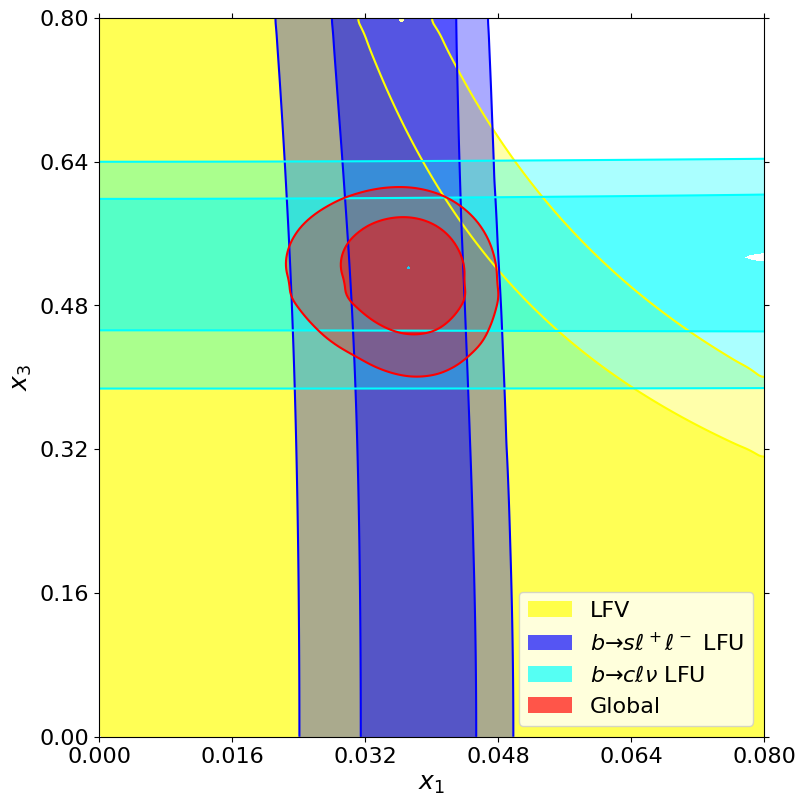

In [17]:
colors = [(1.0, 1.0, 0.0), #yellow
          (0.0, 0.0, 1.0), #blue
          (0.0, 1.0, 1.0), #cyan
          (1.0, 0.0, 0.0), #red
         ] #The R, G, B are in the range 0.0-1.0

fig = likelihoodfits.plot.plot(lhfull, loc='lower right', palette=colors)

or we can use one of the colormaps [defined by matplotlib](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

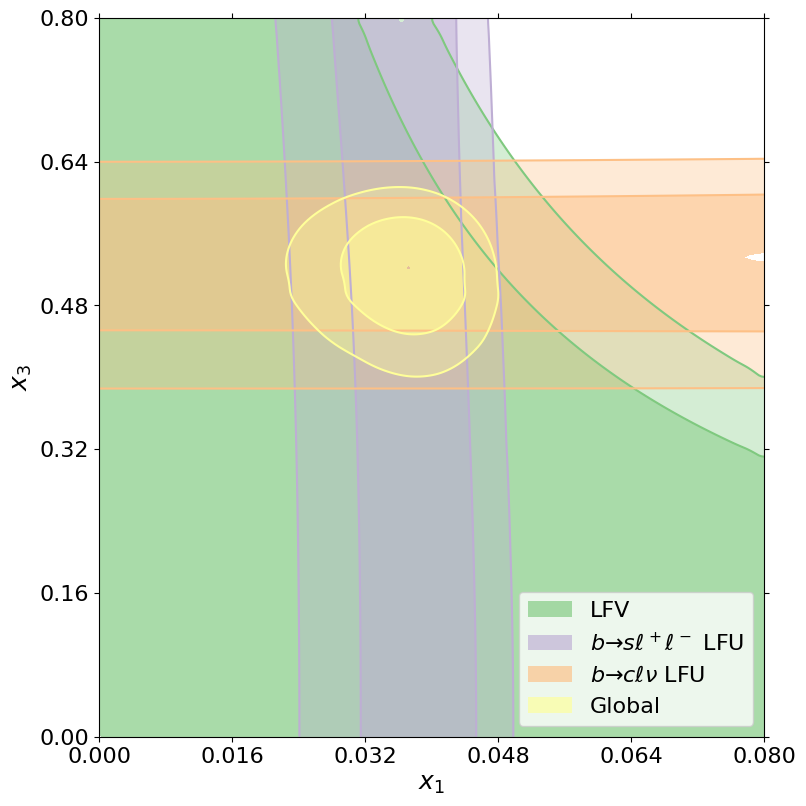

In [18]:
from matplotlib import cm
fig = likelihoodfits.plot.plot(lhfull, loc='lower right', palette=cm.get_cmap('Accent').colors)

We can change the number and significance of the contours

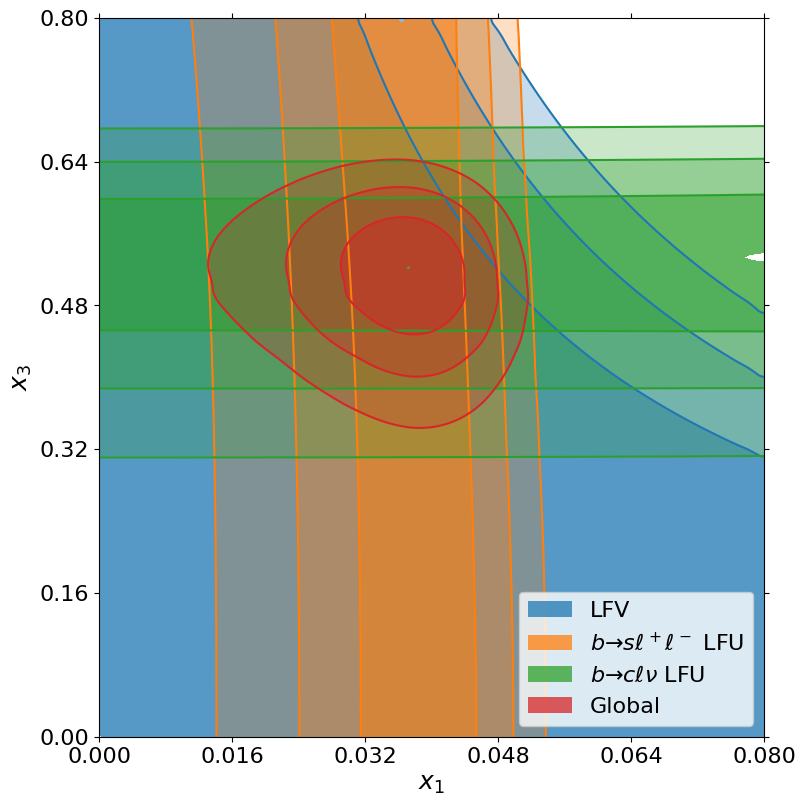

In [19]:
fig = likelihoodfits.plot.plot(lhfull, loc='lower right', n_sigma=(1,2,3))

The returned object is a matplotlib's `Figure`, so we could, in an interactive Python session, do `fig.show()`. 

In [20]:
fig.show()

/tmp/ipykernel_37838/89474557.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


And we can save it to any format supported by matplotlib,

In [24]:
fig.savefig('data/lqU1_simple.pdf')